In [1]:
# Libraries for Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim

# Data analysis and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Animation
from IPython import display
import matplotlib.gridspec as gridspec

# Solving differential equations
import torchdiffeq
from torchdiffeq import odeint

## Waveform from data

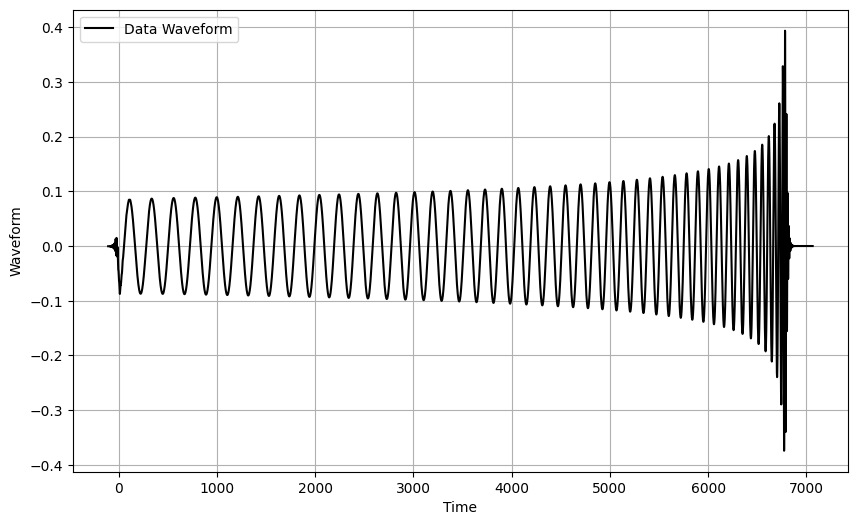

In [2]:
# Convert the data to a pandas frame
data_waveform = pd.read_csv('waveform_real.txt', header=None, delim_whitespace=True, names=['Time', 'Waveform'])

# Plotting the data
plt.figure(figsize=(10, 6)) 
plt.plot(data_waveform['Time'], data_waveform['Waveform'], label='Data Waveform', color = 'black')
plt.xlabel('Time')
plt.ylabel('Waveform')
plt.legend()  
plt.grid(True)
plt.show()

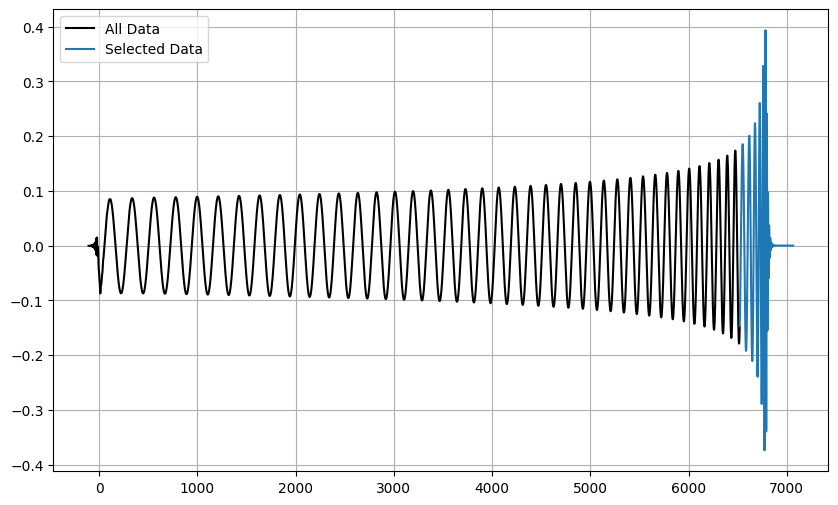

In [3]:
# Calculate the number of points corresponding to the last 34.5%
last_percent = 0.345
num_points = len(data_waveform)
start_index = int(num_points * (1 - last_percent))

# Separate data into first 65.5% and last 34.5%
data_first_part = data_waveform.iloc[:start_index]
data_last_part = data_waveform.iloc[start_index:]

# Plotting the data
plt.figure(figsize=(10, 6)) 
plt.plot(data_first_part['Time'], data_first_part['Waveform'], label='All Data', color='black')
plt.plot(data_last_part['Time'], data_last_part['Waveform'], label='Selected Data')
plt.legend()
plt.grid()

In [4]:
data_waveform.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17291 entries, 0 to 17290
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      17291 non-null  float64
 1   Waveform  17291 non-null  float64
dtypes: float64(2)
memory usage: 270.3 KB


## Neural Network

In [6]:
def SchwGeo(t, y):
    phi = y[:,0]
    chi = y[:,1]

    dphi = (p-2-2*e*torch.cos(chi)) * (1+e*torch.cos(chi))**2 / (M * p**1.5 * torch.sqrt((p-2)**2 - 4*e**2))
    dchi = dphi * torch.sqrt(p - 6 - 2*e*torch.cos(chi)) / torch.sqrt(p)

    return torch.stack((dphi, dchi), 1)

def NewtGeo(t, y):
    phi = y[:,0]
    chi = y[:,1]

    dphi = (1 + e*torch.cos(chi))**2 / (M * p**1.5)
    dchi = dphi
    
    return torch.stack((dphi, dchi), 1)

# Define the Waveform
def waveform(y, dy, ddy):
    phi   = y[:,0]
    chi   = y[:,1]
    dphi  = dy[:,0]
    dchi  = dy[:,1]
    ddphi = ddy[:,0]
    ddchi = ddy[:,1]
    
    r = p * M / (1 + e * torch.cos(chi))
    x = r * torch.cos(phi)
    y = r * torch.sin(phi)
    
    dx = -((dphi*M*p*torch.sin(phi))/(1 + e*torch.cos(chi))) + (dchi*e*M*p*torch.cos(phi)*torch.sin(chi))/(1 + e*torch.cos(chi))**2
    dy = (M*p*(dphi*torch.cos(phi)*(1 + e*torch.cos(chi)) + dchi*e*torch.sin(phi)*torch.sin(chi)))/(1 + e*torch.cos(chi))**2
    
    ddx = -((M*p*(dphi**2*torch.cos(phi)*(1 + e*torch.cos(chi))**2 + (dchi**2*e*torch.cos(phi)*(-2*torch.cos(chi) + e*(-3 + torch.cos(2*chi))))/2. + 2*dphi*dchi*e*(1 + e*torch.cos(chi))*torch.sin(phi)*torch.sin(chi) + (1 + e*torch.cos(chi))*(ddphi*(1 + e*torch.cos(chi))*torch.sin(phi) - ddchi*e*torch.cos(phi)*torch.sin(chi))))/(1 + e*torch.cos(chi))**3)
    ddy = (M*p*(-(dphi**2*(1 + e*torch.cos(chi))**2*torch.sin(phi)) + (dchi**2*e*(3*e + 2*torch.cos(chi) - e*torch.cos(2*chi))*torch.sin(phi))/2. + 2*dphi*dchi*e*torch.cos(phi)*(1 + e*torch.cos(chi))*torch.sin(chi) + (1 + e*torch.cos(chi))*(ddphi*torch.cos(phi)*(1 + e*torch.cos(chi)) + ddchi*e*torch.sin(phi)*torch.sin(chi))))/(1 + e*torch.cos(chi))**3
    
    ddIxx =  (2/3) * (2 * dx**2 - dy**2 + 2 * x*ddx - y*ddy)
    ddIyy = -(2/3) * (dx**2 - 2 * dy**2 + x*ddx - 2 * y*ddy)
    
    return np.sqrt(4*np.pi/5) * (ddIxx - ddIyy)

In [7]:
# Define the Neural Network class
class NetGeo(nn.Module):
    def __init__(self):
        super(NetGeo, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.constant_(m.weight,val=0)
                nn.init.constant_(m.bias, val=0)
        
    def forward(self, t, y):
        yc = torch.cos(y[:,[0]])
        return NewtGeo(t, y) * (1 + self.net(yc))

# Define Orbit class
class GetOrbit(nn.Module):
    def __init__(self, func):
        super(GetOrbit, self).__init__()
        self.func = func
    
    def forward(self, t, y):
        y = odeint(self.func, y0, t, method='dopri5').reshape(t.size()[0],2).to(device)
        phi = y[:,0]
        chi = y[:,1]
        r   = p * M / (1 + e * torch.cos(chi))
        
        return torch.stack((r * torch.cos(phi), r * torch.sin(phi)), 1)

# Define the Waveform class
class GetWaveform(nn.Module):
    def __init__(self, func):
        super(GetWaveform, self).__init__()
        self.func = func
    
    def forward(self, t, y):
        h = t[1] - t[0]
        y = odeint(self.func, y0, t, method='dopri5').reshape(t.size()[0],2).to(device)
        dy = self.func(t, y)
        ddy = (torch.roll(dy, -1, dims=0) - torch.roll(dy, 1, dims=0)) / (2*h)
        ddy[0]  = (dy[1] - dy[0]) / h
        ddy[-1] = (dy[-1] - dy[-2]) / h
        
        return  waveform(y, dy, ddy)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

p  = torch.tensor(100., device = device)
e  = torch.tensor(0.5, device = device)
M  = torch.tensor(1., device = device)

y0 = torch.tensor([[0., np.pi]], device = device)
t_train  = torch.linspace(0., 50000., 1000, device = device)

true_y_fun     = GetWaveform(SchwGeo)
true_y         = true_y_fun(t_train, y0)

netGeo         = NetGeo().to(device)
pred_y_fun     = GetWaveform(netGeo)

optimizer = optim.Adam(netGeo.parameters(), lr=1e-3)

In [18]:
loss_hist = []

num_epochs = 100
for epochs in range(num_epochs):
    pred_y = pred_y_fun(t_train, y0)
    loss = torch.sum((pred_y - true_y)**2)
    loss.backward()
    loss_hist.append(loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if (epochs + 1) % 10 == 0:
        print(f'Epoch [{epochs + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 0.2834320068359375
Epoch [20/100], Loss: 0.11020691692829132
Epoch [30/100], Loss: 0.007369979750365019
Epoch [40/100], Loss: 0.005164965055882931
Epoch [50/100], Loss: 0.006746804807335138
Epoch [60/100], Loss: 0.00167208188213408
Epoch [70/100], Loss: 0.0012132447445765138
Epoch [80/100], Loss: 0.001250394736416638
Epoch [90/100], Loss: 0.0010027638636529446
Epoch [100/100], Loss: 0.0010181377874687314
